# Plot velocity field and model topography

## Tech preamble

In [3]:
%matplotlib inline
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seawater
import xarray as xr

## Start Dask client

We want to be able to control the resources used for parallel computations.

In [4]:
from dask.distributed import Client

In [5]:
client = Client(n_workers=1, threads_per_worker=8, memory_limit=8e9)
client

/opt/tljh/user/envs/py3_euler/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:40361 Dashboard: /user/workshop019/proxy/39299/status,Cluster Workers: 1 Cores: 8 Memory: 8.00 GB


## Parameters

In [6]:
# paramters
global_data_path = Path("/data/iAtlantic/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = "1_"  # leave empty if global data will be used

# chunk sizes
chu_x = 1250
chu_y = 1250
chu_z = 1
chu_t = 1

# region
z = 500
j_bnds = slice(1500, 2000)
i_bnds = slice(500, 1250)

#Saga Array
lon_sa=-9
lat_sa_min=-32
lat_sa_max=-20

---

## Find data files

In [7]:
MESH_MASK_files = list(sorted(
    (global_data_path / "mask" / experiment_id).glob(
        f"{nest_prefix}mesh_mask.nc"
    )
))

U_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_1m_2010*_*_grid_U.nc"
    )
))

V_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_1m_2010*_*_grid_V.nc"
    )
))

print(f"Found {len(MESH_MASK_files)} mesh/mask files, {len(U_files)} U files, and {len(V_files)} V files.")

Found 1 mesh/mask files, 1 U files, and 1 V files.


## Load auxiliary data

We load info about the model grid and about coordinates.

In [8]:
ds_mesh_mask = xr.open_mfdataset(
    MESH_MASK_files,
    chunks={
        "z": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')
ds_mesh_mask = ds_mesh_mask.squeeze()  # remove degenerate time dim
#ds_mesh_mask = ds_mesh_mask.set_coords(["nav_lat", "nav_lon"])

#display(ds_mesh_mask)

## Load velocity data

In [9]:
ds_U = xr.open_mfdataset(
    U_files,
    chunks={
        "time_counter": chu_t,
        "depthu": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')
ds_U = ds_U.rename({"time_counter" : "t", "depthu" : "z"})

In [10]:
U = ds_U.vozocrtx
U = U.where(ds_mesh_mask.umask != 0)

#display(U)

## Looking for the indexes


In [13]:
ds_U.nav_lon.isel(x=1788, y=300).values
ds_U.nav_lat.isel(x=0, y=slice(30, 310, 10)).values

array([-32.754677, -32.33319 , -31.909727, -31.48431 , -31.05695 ,
       -30.62766 , -30.196459, -29.763361, -29.328382, -28.891539,
       -28.452852, -28.012337, -27.570011, -27.125896, -26.68001 ,
       -26.232374, -25.783009, -25.331934, -24.879173, -24.424746,
       -23.968674, -23.510984, -23.051699, -22.590841, -22.128435,
       -21.664507, -21.199081, -20.732187], dtype=float32)

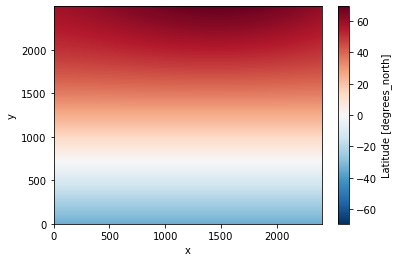

In [14]:
ds_U.nav_lat.plot()

In [15]:
pre_min = 1000;
pre_max = 3000;
prev = ds_U.z.values
ipre_min = (np.abs(prev-pre_min)).argmin()
ipre_max = (np.abs(prev-pre_max)).argmin()

In [16]:
lonv = ds_U.nav_lon.isel(y=0).values
ilonv = (np.abs(lonv-lon_sa)).argmin()

In [17]:
latv = ds_U.nav_lat.isel(x=0).values
ilatv_min = (np.abs(latv-lat_sa_min)).argmin()
ilatv_max = (np.abs(latv-lat_sa_max)).argmin()

In [18]:
U_saga=U.isel(x=ilonv,y=slice(ilatv_min,ilatv_max),z=slice(ipre_min,ipre_max))
e3u_saga=ds_mesh_mask.e3u_0.isel(x=ilonv,y=slice(ilatv_min,ilatv_max),z=slice(ipre_min,ipre_max))
e2u_saga=ds_mesh_mask.e2u.isel(x=ilonv,y=slice(ilatv_min,ilatv_max))

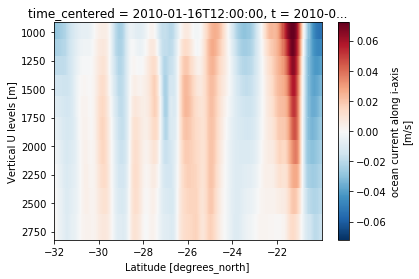

In [19]:
U_saga.isel(t=0).plot(x="nav_lat",y="z",yincrease=False);

In [20]:
accU = (U_saga * e3u_saga* e2u_saga).sum("z").cumsum("y")/ 1.0e6

In [21]:
accU = accU.rename('AccumulatedTransportU')

In [22]:
accUme = accU.mean(dim="t")
accUst = accU.std(dim="t")
# accUst.values

In [23]:
accUme = accUme.compute()

In [24]:
accUst = accUst.compute()

<xarray.DataArray 'AccumulatedTransportU' (t: 12, y: 268)>
dask.array<truediv, shape=(12, 268), dtype=float64, chunksize=(1, 268), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y) float32 dask.array<chunksize=(268,), meta=np.ndarray>
    nav_lon        (y) float32 dask.array<chunksize=(268,), meta=np.ndarray>
    time_centered  (t) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * t              (t) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Dimensions without coordinates: y

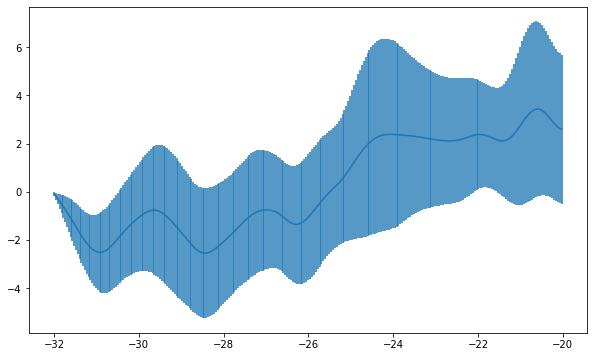

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(x=accUme.nav_lat,y=accUme,yerr=accUst)
#ax.plot(accUme.nav_lat,accUme)
accU